VDP example with Zhang DMD

In [296]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

from odmd import OnlineDMD
import time

In [297]:
%run fDMD_functions.ipynb


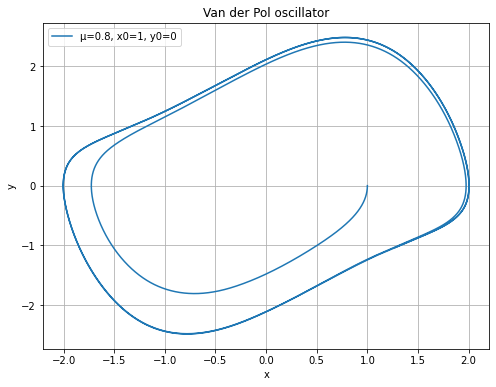

(2, 2001)


In [298]:
#Van der Pol oscillator system
initial_condition = (1,0)
mu = 0.8
t_span=(0,20)
t_eval = np.linspace(t_span[0], t_span[1], 2000001)


def van_der_pol(t, state, mu):
    x, y = state
    dxdt = y
    dydt = mu * (1 - x**2) * y - x
    return [dxdt, dydt]


sol = solve_ivp(van_der_pol, t_span, [initial_condition[0], initial_condition[1]], args=(mu,), t_eval=t_eval, vectorized=True) #u sol.y[0] i sol.y[1] su (x,y) koordinate točke za svaki trenutak

#print(sol.y[0].shape, sol.y[1].shape)
#print(sol.t.shape)

plt.figure(figsize=(8,6))
plt.plot(sol.y[0], sol.y[1], label=f"μ={mu}, x0={initial_condition[0]}, y0={initial_condition[1]}")

    
plt.title("Van der Pol oscillator")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

t_used=np.arange(0,2000001,1000)
del (t_eval)
vdp = sol.y[:,t_used]
#vremenski intervali 0.01, od trena 0 do 20
print(vdp.shape)



In [299]:
(n,m)=vdp.shape

In [300]:
#bez stackanja

q = 10 #toliko uzmem za pocetak
#evalsonlineDMD1 = np.empty((n, m), dtype=complex)
odmd = OnlineDMD(n, 1.0)
odmd.initialize(vdp[:, :q], vdp[:, 1:q+1])
start = time.time()
for k in range(q, m-1):
    odmd.update(vdp[:, k], vdp[:, k+1])
    #evalsonlineDMD1[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 1, time = " + str(end-start) + " secs")

Lambda, Z = odmd.computemodes()
print(Lambda)
print(Z)

Online DMD, weighting = 1, time = 0.07213664054870605 secs
[1.+0.01j 1.-0.01j]
[[0.01-0.71j 0.01+0.71j]
 [0.71+0.j   0.71-0.j  ]]


In [301]:
Z_nas, Lambda_nas, r, Q, L = fGEDMDQ_multiple_trajectories(vdp[:,:q], vdp[:,1:q+1])
start_nas = time.time()
for k in range(q, m-1):
    Z_nas, Lambda_nas, r, Q, L = fDMD_added_snap(np.bmat([vdp[:,k],vdp[:,k+1]]).T, Q, L)
end_nas = time.time()
print("time: ", end_nas-start_nas, "sec")

print(Lambda_nas); print(Z)

#isti rezultati, ali nase puno sporije..

time:  0.7572662830352783 sec
[1.+0.01j 1.-0.01j]
[[0.01-0.71j 0.01+0.71j]
 [0.71+0.j   0.71-0.j  ]]


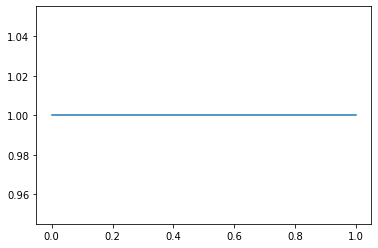

In [302]:
plt.plot(r)

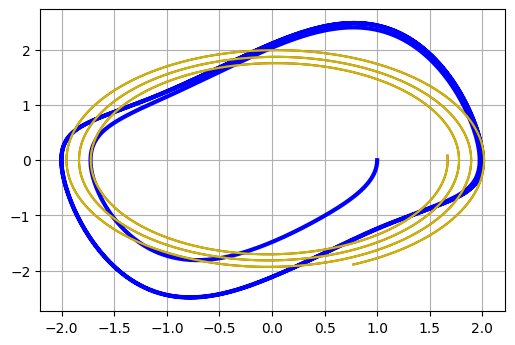

In [303]:
#kako izgleda rekonstrukcija s ovim modovima?
indices=np.array([0,1]); times=[i for i in range(m)]

reconstructed = DMD_reconstruction(vdp, Z_nas, indices, Lambda_nas, times)
reconstructed_zhang = DMD_reconstruction(vdp, Z, indices, Lambda, times)

plt.figure(dpi=100)
plt.plot(vdp[0,:], vdp[1,:], color="blue", lw=3)
plt.plot(reconstructed[0,:], reconstructed[1,:], color="red")
plt.plot(reconstructed_zhang[0,:], reconstructed_zhang[1,:], color="y")
plt.grid()

#jasno da je lose.. moramo stackat - isto za nas i za njihov

# STACKED

In [304]:
#pazi da ne runas vise od jednom..

num_stack = 60
num_stack=30
m=vdp.shape[1]
vdp_end=vdp[:,-num_stack:]
vdp = vdp[:,:(m-num_stack+1)]

for i in range(1,num_stack):
    added=np.concatenate((vdp[:2,i:], vdp[:2,:i]), axis=1)
    vdp=np.vstack((vdp,added))

(n, m)=vdp.shape

In [306]:
q = 300 #toliko uzmem za pocetak
kraj=500
odmd = OnlineDMD(n, 1.0)
odmd.initialize(vdp[:, :q], vdp[:, 1:q+1]) #vec ako ovo rekonstruiram i plotam problemi.. zasto?
start = time.time()
for k in range(q, kraj-1):
    odmd.update(vdp[:, k], vdp[:, k+1])
    #evalsonlineDMD1[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 1, time = " + str(end-start) + " secs")

Lambda, Z = odmd.computemodes()
print(Lambda)
print(Z)

Online DMD, weighting = 1, time = 0.009651660919189453 secs
[-0.88+0.j   -0.88+0.12j -0.88-0.12j -0.86+0.22j -0.86-0.22j -0.8 +0.31j
 -0.8 -0.31j -0.78+0.41j -0.78-0.41j -0.72+0.51j -0.72-0.51j -0.66+0.58j
 -0.66-0.58j -0.58+0.64j -0.58-0.64j -0.51+0.73j -0.51-0.73j -0.41+0.77j
 -0.41-0.77j -0.32+0.82j -0.32-0.82j -0.23+0.82j -0.23-0.82j -0.13+0.87j
 -0.13-0.87j -0.07+0.87j -0.07-0.87j  0.07+0.89j  0.07-0.89j  0.14+0.89j
  0.14-0.89j  0.27+0.84j  0.27-0.84j  0.34+0.84j  0.34-0.84j  0.45+0.76j
  0.45-0.76j  0.53+0.74j  0.53-0.74j  0.61+0.64j  0.61-0.64j  0.68+0.61j
  0.68-0.61j  0.75+0.49j  0.75-0.49j  0.81+0.45j  0.81-0.45j  0.87+0.3j
  0.87-0.3j   0.92+0.26j  0.92-0.26j  0.98+0.13j  0.98-0.13j  0.98+0.06j
  0.98-0.06j  1.  +0.04j  1.  -0.04j  1.  +0.01j  1.  -0.01j  0.87+0.j  ]
[[ 1.66e-02+0.j   -1.38e-02-0.13j -1.38e-02+0.13j ... -2.72e-02-0.12j
  -2.72e-02+0.12j -2.47e-02+0.j  ]
 [ 4.66e-01+0.j    4.43e-01+0.j    4.43e-01-0.j   ...  1.23e-01-0.04j
   1.23e-01+0.04j  4.99e-01+0.j  ]


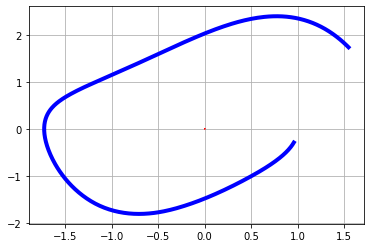

In [282]:
indices_zhang=np.array([i for i in range (Z.shape[1])]); times=[i for i in range(m)]
reconstructed_zhang = DMD_reconstruction(vdp[:,:kraj], Z, indices, Lambda, times)

plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="b", lw=4)
plt.plot(reconstructed_zhang[-2,:kraj], reconstructed_zhang[-1,:kraj], color="r")
plt.grid()
plt.show()

In [283]:
q=300 #moram imati vise od 240 elemenata za sad
Z_nas, Lambda_nas, r, Q, L = fGEDMDQ_multiple_trajectories(vdp[:,:q], vdp[:,1:q+1], tol=1e-6)
start_nas = time.time()
for k in range(q, kraj-1):
    Z_nas, Lambda_nas, r, Q, L = fDMD_added_snap(np.bmat([vdp[:,k],vdp[:,k+1]]).T, Q, L, tol=1e-6)
end_nas = time.time()
print("time: ", end_nas-start_nas, "sec")

print(Lambda_nas); print(Z_nas)


time:  2.337878704071045 sec
[-0.83+0.j   -0.81+0.2j  -0.81-0.2j  -0.76+0.1j  -0.76-0.1j  -0.74+0.38j
 -0.74-0.38j -0.71+0.3j  -0.71-0.3j  -0.63+0.55j -0.63-0.55j -0.62+0.48j
 -0.62-0.48j -0.5 +0.68j -0.5 -0.68j -0.49+0.62j -0.49-0.62j -0.33+0.78j
 -0.33-0.78j -0.33+0.73j -0.33-0.73j -0.15+0.84j -0.15-0.84j -0.14+0.8j
 -0.14-0.8j   0.04+0.85j  0.04-0.85j  0.05+0.82j  0.05-0.82j  0.24+0.83j
  0.24-0.83j  0.25+0.79j  0.25-0.79j  0.42+0.76j  0.42-0.76j  0.43+0.72j
  0.43-0.72j  0.59+0.65j  0.59-0.65j  0.59+0.6j   0.59-0.6j   0.72+0.5j
  0.72-0.5j   0.72+0.45j  0.72-0.45j  0.77+0.31j  0.77-0.31j  0.83+0.31j
  0.83-0.31j  0.92+0.21j  0.92-0.21j  0.97+0.1j   0.97-0.1j   1.  +0.04j
  1.  -0.04j  1.  +0.01j  1.  -0.01j  0.95+0.04j  0.95-0.04j]
[[-4.70e-02+0.00e+00j  4.38e-02+9.13e-03j  4.38e-02-9.13e-03j ...
   1.25e-01+9.38e-03j -4.11e-02-2.42e-02j -4.11e-02+2.42e-02j]
 [-5.52e-01+0.00e+00j  4.53e-01+3.12e-01j  4.53e-01-3.12e-01j ...
   2.08e-02-1.27e-01j  2.93e-01-7.08e-02j  2.93e-01+7.08e-0

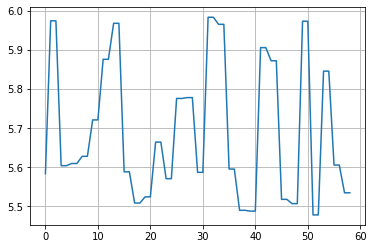

In [284]:
plt.plot(r) #opet vece nego sto smo navikli s overparametrized modelima (ocekivano!)
plt.grid()

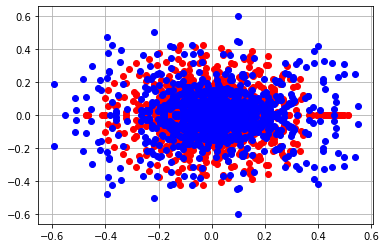

In [285]:
plt.plot(np.real(Z), np.imag(Z), 'o', color="r")
plt.plot(np.real(Z_nas), np.imag(Z_nas), 'o', color="b")
plt.grid()
plt.show()

(59,)
(35,)


Text(0.5, 1.0, 'Some indices - our reconstruction')

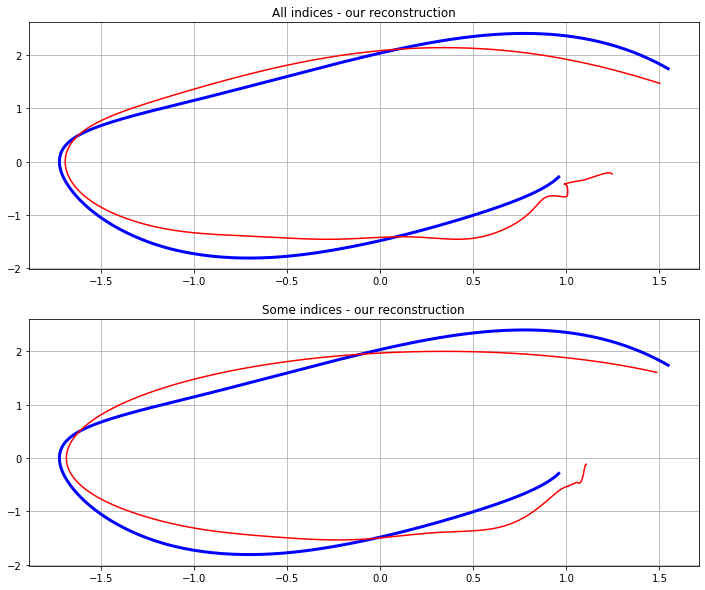

In [286]:
indices_nas=np.array([i for i in range (Z_nas.shape[1])]); times=[i for i in range(m)]
#indices_nas = np.where(r<np.mean(r))[0] #ako s ovime imam 35 indeksa umjesto 59 i slicni rezultat..
print(indices_nas.shape)
reconstructed_nas = DMD_reconstruction(vdp[:,:kraj], Z_nas, indices_nas, Lambda_nas, times)

plt.figure(figsize=(12, 10))

plt.subplot(2,1,1)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_nas[-2,:kraj], reconstructed_nas[-1,:kraj], color="red")
plt.grid()
plt.title("All indices - our reconstruction")


indices_nas = np.where(r<np.mean(r))[0] #ako s ovime imam 35 indeksa umjesto 59 i slicni rezultat..
print(indices_nas.shape)
reconstructed_nas = DMD_reconstruction(vdp[:,:kraj], Z_nas, indices_nas, Lambda_nas, times)

plt.subplot(2,1,2)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_nas[-2,:kraj], reconstructed_nas[-1,:kraj], color="red")
plt.grid()
plt.title("Some indices - our reconstruction")
